# Deep Learning with Time Series data

<div class="questions">

### Questions

- "What is deep learning?"
- "What is a GPU and why do I care?"
</div>

<div class="objectives">

### Objectives

- Run a Tensorflow job
- Predict the weather
</div>

Python offers many ways to make use of the compute capability in your GPU. A very common application is deep learning using the tensorflow and keras (or pytorch) packages. In this example we are going to look at forecasting a timeseries using recurrent neural netowrks based on the history of the time series itself.

We are looking at temperature data in Sydney for the last 150 years with daily measurements (Based on an example from 
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/). We want to predict what the future is going to look like. Note: the default values in the notebook restrict the length of dataset used in the analysis purely for time constraints. But feel free to adjust the numbers as you like. Using a GPU-enabled version of tensorflow will greatly reduce the time training. This deep-learning framework to predict time series data is known Long Short-Term Memory (LSTM) deep learning network.

The data is from the Australian Bureau of Meteorology (BOM) representing the [daily maximum temperatures for the last 150 years from the Sydney Observatory](http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=122&p_display_type=dailyDataFile&p_startYear=&p_c=&p_stn_num=066062)

A problem might be, given the last few decades of temperature cycles, what will tomorrow's weather be? Let's try and predict the future!


In [1]:
#import all the libraries we need
import numpy
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MaxAbsScaler 

In [2]:
#Load in the dataset
filename='../data/sydney_temperature.csv'
dataframe = pd.read_csv(filename, usecols=[5], engine='python')
dataset = dataframe.dropna()
dataset = dataset.values
dataset = dataset.astype('float32')

# normalize the dataset to be betwenn 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
datasetScaled = scaler.fit_transform(dataset)

In [3]:
#Print some stats about the data
print(dataframe.describe())

       Maximum temperature (Degree C)
count                    58316.000000
mean                        21.731120
std                          4.669517
min                          7.700000
25%                         18.200000
50%                         21.600000
75%                         24.900000
max                         45.800000


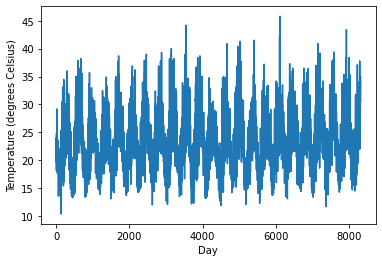

In [12]:
#Look at some of the data set
#This is the temperature throughout the year.
#The summer and winter cycles are obvious
#But there is a fair bit of variablity day-to-day
plt.plot(dataset[50000:])
plt.xlabel("Day")
plt.ylabel("Temperature (degrees Celsius)");

In [5]:
# split into train and test sets
#Use the first 58000 days as training
train=datasetScaled[0:58000,:]
#Use from 55000 to 58316 as testing set, 
#that means we will test on 3000 days we know the answer for, 
#leaving 316 that the algorithm has never seen!
test=datasetScaled[55000:,:]

print("Traing set is: ", train.shape)
print("Test set is: ", test.shape)

Traing set is:  (58000, 1)
Test set is:  (3316, 1)


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# previous time steps to use as input variables to predict the next time period
look_back = 30 

# reshape into X=t and Y=t+look_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [7]:
# create the LSTM network
#The network has a visible layer with 1 input, 
#a hidden layer with 4 LSTM blocks or neurons, 
#and an output layer that makes a single value prediction. 
#The default sigmoid activation function is used for the LSTM blocks. 
#The network is trained for 4 epochs and a batch size of 1 is used.

print("Running model...")
model = tf.keras.models.Sequential()

print("Adding LSTM.")
model.add(tf.keras.layers.LSTM(4, input_shape=(look_back, 1)))

print("Adding dense.")
model.add(tf.keras.layers.Dense(1))

print("Compiling.")
model.compile(loss='mean_squared_error', optimizer='adam')

Running model...
Adding LSTM.
Adding dense.
Compiling.


In [8]:
#Fit the model, this takes the longest time
print("fitting...")
startT=time.time()
model.fit(trainX, trainY, epochs=4, batch_size=30, verbose=1)
endT=time.time()

print("Time taken: ", endT-startT)

fitting...
Epoch 1/4


2022-08-23 15:47:52.934724: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1933/1933 [==============================] - 8s 4ms/step - loss: 0.0168
Epoch 2/4
1933/1933 [==============================] - 7s 4ms/step - loss: 0.0066
Epoch 3/4
1933/1933 [==============================] - 7s 4ms/step - loss: 0.0063
Epoch 4/4
1933/1933 [==============================] - 7s 4ms/step - loss: 0.0060
Time taken:  28.57616114616394


In [9]:
#Save or load the model
#model.save('kerasmodel.hdf5')
#model = tf.keras.models.load_model('kerasmodel.hdf5')

In [10]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert and rescale predictions
trainPredicti = scaler.inverse_transform(trainPredict)
trainYi = scaler.inverse_transform([trainY])
testPredicti = scaler.inverse_transform(testPredict)
testYi = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYi[0], trainPredicti[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYi[0], testPredicti[:,0]))
print('Test Score: %.4f RMSE' % (testScore))


103/103 [==============================] - 0s 861us/step
Train Score: 2.9189 RMSE
Test Score: 2.9696 RMSE


(55000, 1) (3285, 1) (58316, 1)
(57969, 1) (3285, 1) (58285, 1)


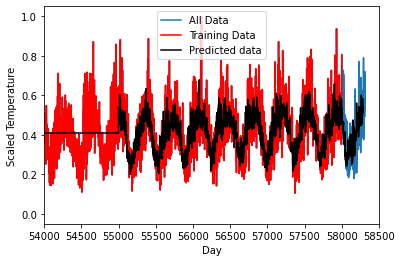

In [11]:
#PLOT the result

#Create a dataset that is the same size as the testing/training set 
dummyfull=numpy.ones((datasetScaled.shape[0]-test.shape[0],1))*numpy.mean(testPredict)
print(dummyfull.shape,testPredicti.shape,datasetScaled.shape)
testvec = numpy.concatenate((dummyfull,testPredict))

#Scale the data
transformer = MaxAbsScaler().fit(train[:])
testScale= transformer.transform(testvec)

print(trainPredict.shape,testPredict.shape,testvec.shape)

train=datasetScaled[0:58000,:]
#Use from 50000 to 58316 as testing set, 
#that means we will test on 8000 days we know the answer for, 
#leaving 316 that the algorithm has never seen!
test=datasetScaled[55000:,:]

plt.plot(datasetScaled[:])
plt.plot(train[:],'r')
plt.plot(testScale[:],'k')

plt.legend(["All Data","Training Data","Predicted data"])
plt.xlabel("Day")
plt.ylabel("Scaled Temperature")
plt.xlim([54000,58500])
plt.show()

Depending on the environment you are working in, you will have to use a different combo of python/cuda/tensorflow/keras versions and GPU hardware. Check compatability for [NVIDIA Drivers/CUDA](https://docs.nvidia.com/deploy/cuda-compatibility/index.html), [CUDA/Python/Tensorflow](https://www.tensorflow.org/install/source#tested_build_configurations).

In Deep Learning, *training* the model can take a seriously long time, so we often only want to do this once and then tweak our model. In which case we can do that by saving out our data as as a *\*.hdf5* file. 

<div class="challenge">

### Challenge

Pick another site at [http://www.bom.gov.au/climate/data/](http://www.bom.gov.au/climate/data/) and re-run the analysis. 

<details>
<summary>Solution</summary>

...

</details>
</div>  



